In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Для запуска графического ядра
import time

def time_matmul(x):
  start = time.time()
  for loop in range(100):
    tf.matmul(x, x)

  result = time.time()-start

  print("100 циклов: {:0.2f}ms".format(1000*result))

for i in range(2):
    # исполнение CPU
    print(" CPU работает:")
    with tf.device("CPU:0"):
      x = tf.random.uniform([1000, 1000])
      assert x.device.endswith("CPU:0")
      time_matmul(x)

    # исполнение на GPU #0 , если доступен
    if tf.config.experimental.list_physical_devices("GPU"):
      print(" какой GPU:")
      with tf.device("GPU:0"): # или GPU:1 , для 2х GPU, GPU:2 для 3х  и т.д.
        x = tf.random.uniform([1000, 1000])
        assert x.device.endswith("GPU:0")
        time_matmul(x)

 CPU работает:
100 циклов: 364.33ms
 какой GPU:
100 циклов: 365.81ms
 CPU работает:
100 циклов: 350.32ms
 какой GPU:
100 циклов: 6.01ms


In [2]:
from __future__ import print_function
import tensorflow.keras as keras 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Input,AveragePooling2D
from tensorflow.keras.models import Model 
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [3]:
def testing(model,num_iter):
    start = time.time()
    res=[]
    res_tr=[]
    for _ in range(num_iter):
        model.set_weights(ww)
        hh = model.fit(x=x_train,y=y_train, epochs=epochs,\
                       batch_size=batch_size, validation_data=(x_test, y_test), verbose=0)
        res.append(hh.history['val_accuracy'][-1])
        res_tr.append(hh.history['accuracy'][-1])
    res = np.array(res)
    
    d={'epochs':epochs,
        'res_max' : res.max(),
        'res_min' : res.min(),
        'res_mean' : res.mean(),
        'res_std' : res.std(),
       'batch_size':batch_size,
       'res_train_mean':np.array(res_tr).mean(),
       'time_iter': (time.time() - start)/num_iter
    }    
    
    return d
        
    
    

In [4]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']
num_classes = len(classes)

In [5]:


# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [6]:
# установка параметров нейросети
batch_size = 256
num_classes = len(classes)
epochs = 5
ep_list=[4,8]
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
data_augmentation = False
inpit_shape = x_test.shape[1:]

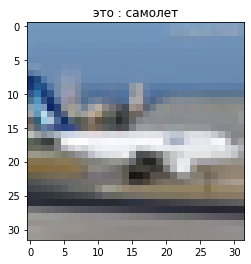

In [7]:
N = 90

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

### переобучения модели не видно  
0.66 на трейне и 0,62 на валидации
Но все же попробуем Попробуем Dropout(0.2) на свертках

In [8]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = MaxPooling2D(pool_size = 3,strides =2)(x1)
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = MaxPooling2D(pool_size = 3,strides =2)(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = AveragePooling2D(pool_size = 3,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_1 = Model(inputs = input_1,outputs = out,name = 'model_1' )
model_1.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_1.get_weights()

In [9]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 96)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2214

In [10]:
history = pd.DataFrame()

In [11]:
%%time
for epochs in ep_list:
    res = testing(model_1,2)
    res['model'] = 'model_1'
    history=history.append(res,ignore_index=True)
history
    

Wall time: 5min 44s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1,0.28155,0.36122,172.415071


следуюшая модель

In [12]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=36,kernel_size = 9,strides =1,activation = 'relu',padding = 'same')(input_1)
# x1 = Conv2D(filters=36,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
# x1 = Conv2D(filters=36,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1)
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 5,strides =1,activation = 'relu',padding = 'same')(x1)
# x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
# x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(x2)
# x3 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(x3)
# x3 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = AveragePooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_2=Model(inputs = input_1,outputs = out ,name = 'Model_2')
model_2.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_2.get_weights()

In [13]:
model_2.summary()

Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 36)        8784      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 36)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 36)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 256)       230656    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8, 8, 256)         0   

In [14]:
%%time
for epochs in ep_list:
    res = testing(model_2,5)
    res['model'] = 'model_2'
    history=history.append(res,ignore_index=True)
history

Wall time: 10min 12s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017


In [15]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=128,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = Conv2D(filters=128,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = Conv2D(filters=128,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1)
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = MaxPooling2D(pool_size = 3,strides =2)(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = AveragePooling2D(pool_size = 4,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_3=Model(inputs = input_1,outputs = out,name = 'model_3' )
model_3.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_3.get_weights()

In [16]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       1664      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 128)       262272    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 256)       1313

In [17]:
%%time
res = testing(model_3,5)
res['model'] = 'model_3'
history=history.append(res,ignore_index=True)
history

Wall time: 51min 39s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017
3,256.0,8.0,model_3,0.7455,0.35160,0.1000,0.308322,0.349872,619.816652


In [18]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = MaxPooling2D(pool_size = 3,strides =2)(x1)
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = MaxPooling2D(pool_size = 3,strides =2)(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = MaxPooling2D(pool_size = 3,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_4 = Model(inputs = input_1,outputs = out,name = 'model_4' )
model_4.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_4.get_weights()

In [19]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 96)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 15, 15, 256)       2214

In [20]:
%%time
res = testing(model_4,5)
res['model'] = 'model_4'
history=history.append(res,ignore_index=True)
history

Wall time: 27min 57s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017
3,256.0,8.0,model_3,0.7455,0.35160,0.1000,0.308322,0.349872,619.816652
4,256.0,8.0,model_4,0.7594,0.23188,0.1000,0.263760,0.232240,335.506331


In [21]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=128,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
# x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
# x1 = Conv2D(filters=96,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = MaxPooling2D(pool_size = 2,strides =2)(x1)
# x1 = Dropout(0.2)(x1)
x1= Flatten()(x1)

x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
# x2 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x2)
# x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = MaxPooling2D(pool_size = 2,strides =3)(x2)
# x2 = Dropout(0.2)(x2)
x2= Flatten()(x2)

x3 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(input_1)
# x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
# x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = MaxPooling2D(pool_size = 2,strides =4)(x3)
# x3 = Dropout(0.2)(x3)
x3= Flatten()(x3)

merge = Concatenate()([x1,x2,x3])

x4 = Flatten()(merge)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
out = Dense(10,activation='softmax')(x4)

model_5 = Model(inputs = input_1,outputs = out,name = 'model_5' )
model_5.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_5.get_weights()

In [22]:
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 32, 32, 128)  1664        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 32, 32, 256)  7168        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 32, 32, 512)  25088       input_5[0][0]                    
____________________________________________________________________________________________

In [23]:
%%time
res = testing(model_5,5)
res['model'] = 'model_5'
history=history.append(res,ignore_index=True)
history

Wall time: 11min 43s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017
3,256.0,8.0,model_3,0.7455,0.35160,0.1000,0.308322,0.349872,619.816652
4,256.0,8.0,model_4,0.7594,0.23188,0.1000,0.263760,0.232240,335.506331
5,256.0,8.0,model_5,0.6801,0.67032,0.6577,0.007621,0.872908,140.601446


In [24]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 3,strides =2)(x1)
x1 = Dropout(0.2)(x1)




x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x3 = MaxPooling2D(pool_size = 3,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_6 = Model(inputs = input_1,outputs = out,name = 'model_6' )
model_6.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_6.get_weights()

In [25]:
model_6.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 15, 15, 512)       1180160   
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 512)         0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 7, 512)         0   

In [26]:
%%time
res = testing(model_6,5)
res['model'] = 'model_6'
history=history.append(res,ignore_index=True)
history

Wall time: 12min 2s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017
3,256.0,8.0,model_3,0.7455,0.35160,0.1000,0.308322,0.349872,619.816652
4,256.0,8.0,model_4,0.7594,0.23188,0.1000,0.263760,0.232240,335.506331
5,256.0,8.0,model_5,0.6801,0.67032,0.6577,0.007621,0.872908,140.601446
6,256.0,8.0,model_6,0.7616,0.75086,0.7425,0.006238,0.790752,144.563462


In [27]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=256,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = Conv2D(filters=256,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x1)
x1 = MaxPooling2D(pool_size = 3,strides =2)(x1)
x1 = Dropout(0.2)(x1)


x2 = Conv2D(filters=512,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = Conv2D(filters=512,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x2)
x2 = MaxPooling2D(pool_size = 3,strides =2)(x2)
x2 = Dropout(0.2)(x2)

x3 = Conv2D(filters=1024,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = Conv2D(filters=1024,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = Conv2D(filters=1024,kernel_size = 4,strides =1,activation = 'relu',padding = 'same')(x3)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)
x3 = Dropout(0.2)(x3)


x4 = Flatten()(x3)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_7 = Model(inputs = input_1,outputs = out,name = 'model_7' )
model_7.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_7.get_weights()

In [28]:
model_7.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 256)       3328      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 256)       1048832   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 15, 15, 512)       5248

In [29]:
%%time
res = testing(model_7,5)
res['model'] = 'model_7'
history=history.append(res,ignore_index=True)
history

Wall time: 3h 32min 19s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017
3,256.0,8.0,model_3,0.7455,0.35160,0.1000,0.308322,0.349872,619.816652
4,256.0,8.0,model_4,0.7594,0.23188,0.1000,0.263760,0.232240,335.506331
5,256.0,8.0,model_5,0.6801,0.67032,0.6577,0.007621,0.872908,140.601446
6,256.0,8.0,model_6,0.7616,0.75086,0.7425,0.006238,0.790752,144.563462
7,256.0,8.0,model_7,0.7552,0.23768,0.1000,0.259079,0.240328,2547.956894


In [30]:
input_1 = Input(shape=inpit_shape)
x1 = Conv2D(filters=128,kernel_size = 2,strides =1,activation = 'relu',padding = 'same')(input_1)
x1 = MaxPooling2D(pool_size = 3,strides =2)(x1)



x2 = Conv2D(filters=256,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x1)
x2 = MaxPooling2D(pool_size = 2,strides =2)(x2)


x3 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x2)
x3 = MaxPooling2D(pool_size = 2,strides =2)(x3)

x33 = Conv2D(filters=512,kernel_size = 3,strides =1,activation = 'relu',padding = 'same')(x3)
x33 = MaxPooling2D(pool_size = 2,strides =2)(x33)


x4 = Flatten()(x33)
x4 = Dense(300,activation='sigmoid')(x4)
x4 = Dropout(0.2)(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dense(300,activation='relu')(x4)
x4 = Dropout(0.2)(x4)
out = Dense(10,activation='softmax')(x4)

model_8 = Model(inputs = input_1,outputs = out,name = 'model_8' )
model_8.compile( optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
ww = model_8.get_weights()

In [31]:
%%time
res = testing(model_8,5)
res['model'] = 'model_8'
history=history.append(res,ignore_index=True)
history

Wall time: 7min 49s


,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017
3,256.0,8.0,model_3,0.7455,0.35160,0.1000,0.308322,0.349872,619.816652
4,256.0,8.0,model_4,0.7594,0.23188,0.1000,0.263760,0.232240,335.506331
5,256.0,8.0,model_5,0.6801,0.67032,0.6577,0.007621,0.872908,140.601446
6,256.0,8.0,model_6,0.7616,0.75086,0.7425,0.006238,0.790752,144.563462
7,256.0,8.0,model_7,0.7552,0.23768,0.1000,0.259079,0.240328,2547.956894
8,256.0,8.0,model_8,0.7723,0.74668,0.7319,0.014226,0.801440,93.855528


In [32]:
history.sort_values('res_mean',ascending=False,inplace=True)
history

,batch_size,epochs,model,res_max,res_mean,res_min,res_std,res_train_mean,time_iter
6,256.0,8.0,model_6,0.7616,0.75086,0.7425,0.006238,0.790752,144.563462
8,256.0,8.0,model_8,0.7723,0.74668,0.7319,0.014226,0.801440,93.855528
2,256.0,8.0,model_2,0.6997,0.68378,0.6484,0.018190,0.686356,81.287017
5,256.0,8.0,model_5,0.6801,0.67032,0.6577,0.007621,0.872908,140.601446
1,256.0,4.0,model_2,0.6028,0.58398,0.5590,0.016938,0.553644,41.240891
0,256.0,4.0,model_1,0.6631,0.38155,0.1000,0.281550,0.361220,172.415071
3,256.0,8.0,model_3,0.7455,0.35160,0.1000,0.308322,0.349872,619.816652
7,256.0,8.0,model_7,0.7552,0.23768,0.1000,0.259079,0.240328,2547.956894
4,256.0,8.0,model_4,0.7594,0.23188,0.1000,0.263760,0.232240,335.506331


судя по всему нужно быть по проще и метрики подлтянуться :)

Возмеме  первые четыре модели и еще раз прогоним на разное количестиво эпох

In [36]:
models= history.iloc[:4,2]

In [ ]:
%%time
for model in models:
    model = eval(model)
    ww = model.get_weights()
    for epochs in [5,10]:
        res = testing(model,5)
        res['model'] = model.name
        history=history.append(res,ignore_index=True)
history.sort_values('res_mean',ascending=False,inplace=True)
history
        